In [1]:
import numpy as np
import abcpmc
import matplotlib.pyplot as plt
from interruptible_pool import InterruptiblePool
import time
%matplotlib inline

In [2]:
from halotools.empirical_models import Zheng07

igraph package not installed.  Some functions will not be available.


/usr/local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


# HOD Parameters and Equations

$$< N_{cen}> = \frac{1}{2} ( 1 + erf ( \frac{\log M - \log M_{min}}{\sigma_{\log M}} ) )$$

$$< N_{sat}> = \frac{1}{2} ( 1+ erf( \frac{\log M - \log M_{min}}{\sigma_{\log M}} ) ) (\frac{M - M_0}{M_1})^\alpha$$

# Data (fake)

$\bar{n}(z)$ and $\xi(r)$ for $r = $ some value

In [4]:
model = Zheng07(threshold = -20.5)
print 'Data HOD Parameters ', model.param_dict

n_avg = 25
avg_nz, avg_corr = 0., 0.
xis = [] 
for i in xrange(n_avg): 
    
    model.populate_mock()
    
    # number density
    avg_nz += model.mock.number_density
    
    # 6th element of xi(r) array
    r, xi_r = model.mock.compute_galaxy_clustering()
    
    avg_corr += xi_r[6]
    
    xis.append(xi_r)

xis = np.array(xis)

avg_nz /= np.float(n_avg)

avg_xi = np.sum(xis, axis=0)/np.float(n_avg)
sig_xi = np.std(xis, axis=0)
avg_corr /= np.float(n_avg)
print 'r, avg_xi, sig_xi'
for i in xrange(len(r)): 
    print r[i], avg_xi[i], sig_xi[i]

data = [avg_nz, avg_xi]

# alpha, m_min, sigma, m0, m1
data_hod = np.array([1.12, 12.3])#, 0.21, 11.84, 13.58])

Data HOD Parameters  {'logM0': 11.84, 'sigma_logM': 0.21, 'logMmin': 12.3, 'alpha': 1.12, 'logM1': 13.58}
r, avg_xi, sig_xi
0.122390952343 2043.53066863 74.0800565777
0.177199951966 964.904316458 29.6753166538
0.256553465559 444.587525437 11.2535898179
0.371442993974 199.683886003 6.2534221701
0.537782241499 92.1589687261 3.68369623061
0.778611372306 43.7735602526 1.27674220649
1.12728837493 20.0458631462 0.528565877568
1.63210958052 9.3060755895 0.150309092349
2.36299933725 4.69881469793 0.058534946868
3.42119544818 2.56537735676 0.029077668035
4.95327193291 1.48745367366 0.015920466752
7.17144144875 0.847352673713 0.0104872372054
10.382949523 0.450737624843 0.0063071423534
15.0326320819 0.226012948272 0.00399773891782


# Model $\Phi({\bf \theta})$

Given $\theta$ which specify HOD parameters, compute $\bar{n}(z)$ and $\xi({\bf r})$. 

In [5]:
class HODsim(object): 
    
    def __init__(self): 
        self.model = Zheng07(threshold = -20.5)
    
    def sum_stat(self, theta_star):
        """
        alpha
        m_min
        sigma
        m0
        m1
        """
        # 'alpha': {'shape': 'gauss', 'mean': 1.1, 'stddev': 0.1}, 
        # 'm_min': {'shape': 'gauss', 'mean': 12.25, 'stddev': 0.25}, 
        # 'sigma': {'shape': 'gauss', 'mean': 0.2, 'stddev': 0.1},
        # 'm0': {'shape': 'gauss', 'mean': 11.8, 'stddev': 0.25}, 
        # 'm1': {'shape': 'gauss', 'mean': 13.5, 'stddev': 0.25}

        
        self.model.param_dict['alpha'] = theta_star[0]
        self.model.param_dict['logMmin'] = theta_star[1]
        #self.model.param_dict['sigma_logM'] = theta_star[2]
        #self.model.param_dict['logM0'] = theta_star[3]
        #self.model.param_dict['logM1'] = theta_star[4]
        
        self.model.populate_mock()
        
        nz = self.model.mock.number_density
        
        r, xi_r = self.model.mock.compute_galaxy_clustering(N_threads = 1)
        
        return [nz, xi_r]

ourmodel = HODsim()
simz = ourmodel.sum_stat

# Distance Measurement
Simple distance measure between the data and the model specific for "sum_stat"
$$ \rho =  \left|\frac{\bar{n}_\mathrm{data} - \bar{n}_\mathrm{model}}{\bar{n}_\mathrm{data}}\right| + \left|\frac{\xi_\mathrm{data} - \xi_\mathrm{model}}{\xi_\mathrm{data}}\right|$$

In [6]:
def distance(d_data, d_model, type = 'sum_stat'): 
    
    if type == 'sum_stat': 
        
        dist_nz = np.abs(d_data[0] - d_model[0])/d_data[0]
        dist_xi = np.sum(np.abs(d_data[1] - d_model[1])/d_data[1])
        dist = dist_nz + dist_xi 
        #print d_data[1]
        #print d_model[1]
        #print sig_xi
        
        #dist = np.sum((d_data[1] - d_model[1]/sig_xi)**2)
        #dist_xi = np.sum(np.abs(d_data[1] - d_model[1])/d_data[1])
        
    return dist 

# Prior 

Below is the Prior Object

In [7]:
from scipy.stats import uniform
from scipy.stats import norm

class Prior(object): 
    def __init__(self, prior_dict): 
        self.prior_dict = prior_dict.copy()
    
    def prior(self): 
        priorz = [] 
        for key in self.prior_dict.keys(): 
            
            prior_key = self.prior_dict[key]
            
            if prior_key['shape'] == 'uniform': 
                
                loc = prior_key['min']
                scale = prior_key['max'] - prior_key['min']
                
                priorz.append( uniform(loc, scale))
            
            elif prior_key['shape'] == 'gauss':
                
                loc = prior_key['mean']
                scale = prior_key['stddev']
                
                priorz.append( norm(loc, scale) )
                
        return priorz

# Specify Prior Here

In [8]:
# Data HOD Parameters  {'logM0': 11.84, 'sigma_logM': 0.21, 'logMmin': 12.3, 'alpha': 1.12, 'logM1': 13.58}
"""
prior_dict = { 
    'alpha': {'shape': 'gauss', 'mean': 1.1, 'stddev': 0.1}, 
    'm_min': {'shape': 'gauss', 'mean': 12.25, 'stddev': 0.25}, 
    'sigma': {'shape': 'gauss', 'mean': 0.2, 'stddev': 0.05},
    'm0': {'shape': 'gauss', 'mean': 11.8, 'stddev': 0.25}, 
    'm1': {'shape': 'gauss', 'mean': 13.5, 'stddev': 0.25}
}

prior_dict = { 
    'alpha': {'shape': 'uniform', 'min': 1.0, 'max': 1.2}, 
    'm_min': {'shape': 'uniform', 'min': 12.0, 'max': 12.6}, 
    'sigma': {'shape': 'uniform', 'min': 0.1, 'max': 0.3},
    'm0': {'shape': 'uniform', 'min': 11.5, 'max': 12.1}, 
    'm1': {'shape': 'uniform', 'min': 13.25, 'max': 13.75}
}
"""
prior_dict = {
    'alpha': {'shape': 'uniform', 'min': 1.0, 'max': 1.2}, 
    'm_min': {'shape': 'uniform', 'min': 12.0, 'max': 12.6}
}

n_params = len(prior_dict.keys())
prior_obj = Prior(prior_dict) 

## Prior Sampler
Function that samples the prior distribution to return $\theta_*$

In [11]:
def prior_sampler(): 
    """ Sample prior distribution and return theta_star 
    """
    theta_star = np.zeros(n_params)
    
    for i in xrange(n_params): 
        np.random.seed()
        theta_star[i] = prior_obj.prior()[i].rvs(size=1)[0]
        
    return theta_star

print 'Prior Sampler Test : '
for i in xrange(3): 
    samp = prior_sampler()
    print 'Sampled prior, ', samp
    print 'Model(theta) ', simz(samp)[1]
    print 'Distance', distance(data, simz(samp))

def pi_priors(tmp_theta): 
    for i in xrange(n_params): 
        try:
            p_theta *= prior_obj.prior()[i].pdf(tmp_theta[i])
        except UnboundLocalError: 
            p_theta = prior_obj.prior()[i].pdf(tmp_theta[i])
            
    return p_theta 

Prior Sampler Test : 
Sampled prior,  [  1.11376609  12.44054474]
Model(theta)  [  3.34103272e+03   1.59454032e+03   7.09688098e+02   3.15642159e+02
   1.36929843e+02   6.15818889e+01   2.47513020e+01   1.09003826e+01
   5.31367782e+00   2.98724234e+00   1.68053547e+00   9.80888342e-01
   5.11866982e-01   2.46791025e-01]
Distance 4.54825981925
Sampled prior,  [  1.09979153  12.43795159]
Model(theta)  [  3.25338390e+03   1.55039128e+03   7.02636832e+02   3.04807317e+02
   1.32819733e+02   6.00505417e+01   2.67987380e+01   1.12924693e+01
   5.40655957e+00   2.89421488e+00   1.66563021e+00   9.61631653e-01
   5.10663888e-01   2.51569787e-01]
Distance 3.86281828044
Sampled prior,  [  1.19564846  12.58530107]
Model(theta)  [  4.89797839e+03   2.33810401e+03   1.15261129e+03   5.30881086e+02
   2.59328751e+02   1.13269526e+02   4.51152442e+01   1.56489047e+01
   6.55351787e+00   3.57850665e+00   1.96810960e+00   1.12237535e+00
   5.82245758e-01   2.94996479e-01]
Distance 13.4702716831


In [12]:
import corner 
import seaborn as seabreeze

"""
{
    'alpha': {'shape': 'gauss', 'mean': 1.1, 'stddev': 0.1}, 
    'm_min': {'shape': 'gauss', 'mean': 12.25, 'stddev': 0.25}, 
    'sigma': {'shape': 'gauss', 'mean': 0.2, 'stddev': 0.05},
    'm0': {'shape': 'gauss', 'mean': 11.8, 'stddev': 0.25}, 
    'm1': {'shape': 'gauss', 'mean': 13.5, 'stddev': 0.25}
}
"""
plot_range = []
for key in ['alpha', 'm_min']: #, 'sigma', 'm0', 'm1']: 
    plot_range.append((prior_dict[key]['min'], prior_dict[key]['max']))
print plot_range

def plot_thetas(theta, w): 
    fig = corner.corner(
        theta.T, weights = w, smooth=True, truths = data_hod, truth_color = 'red', 
        range=plot_range, 
        labels=[r"$\alpha$", r"$log M_{min}$"]
    )
        #, r"$\sigma$", r"$log M_{0}$", r"$log M_{1}$"]
        #)

[(1.0, 1.2), (12.0, 12.6)]


# PMC-ABC

## Initial Pool

In [18]:
N_threads = 4
N_particles = 100
N_iter = 20
eps0 = 20

def initial_pool_sampling(i_particle): 
    """ Sample theta_star from prior distribution for the initial pool
    
    returns [i_particle, theta_star, weights, rho]
    """
    theta_star = prior_sampler()
    model_theta = simz(theta_star)
    
    rho = distance(data, model_theta)
    
    while rho > eps0: 
        
        theta_star = prior_sampler()
        model_theta = simz(theta_star)

        rho = distance(data, model_theta)
        
    pool_list = [np.int(i_particle)]
    for i_param in xrange(n_params): 
        pool_list.append(theta_star[i_param])
    pool_list.append(1./np.float(N_particles))
    pool_list.append(rho)
    
    return np.array(pool_list)

In [19]:
def initial_pool():

    pool = InterruptiblePool(processes = N_threads)
    mapfn = pool.map
    args_list = [i for i in xrange(N_particles)]
    
    #results = [] 
    #for args in args_list: 
    #    pool_sample = initial_pool_sampling(args)
    #    print pool_sample
    #    results.append( pool_sample )
    results = mapfn(initial_pool_sampling, args_list)
    
    pool.close()
    pool.terminate()
    pool.join()
    
    results = np.array(results).T
    theta_t = results[1:n_params+1,:]
    w_t = results[n_params+1,:]
    rhos = results[n_params+2,:]
    
    sig_t = np.cov(theta_t)
    
    return theta_t, w_t, rhos, sig_t

# Beyond the Initial Pool

## Weighted Sampling

In [20]:
def weighted_sampling(theta, w): 
    """ Given array of thetas and their corresponding weights, sample
    """
    w_cdf = w.cumsum()/w.sum() # normalized CDF
    
    np.random.seed()
    rand1 = np.random.random(1)
    cdf_closest_index = np.argmin( np.abs(w_cdf - rand1) )
    closest_theta = theta[:, cdf_closest_index]
    
    return closest_theta

def better_multinorm(theta_stst, theta_before, cov): 
    n_par, n_part = theta_before.shape
    
    sig_inv = np.linalg.inv(cov)
    x_mu = theta_before.T - theta_stst

    nrmliz = 1.0 / np.sqrt( (2.0*np.pi)**n_par * np.linalg.det(cov))

    multinorm = nrmliz * np.exp(-0.5 * np.sum( (x_mu.dot(sig_inv[None,:])[:,0,:]) * x_mu, axis=1 ) )

    return multinorm

In [21]:
from scipy.stats import multivariate_normal 

def importance_pool_sampling(args): 
    # args = [i_particle, theta_t_1, w_t_1, sig_t_1, eps_t]
    i_particle = args[0]
    theta_t_1 = args[1]
    w_t_1 = args[2]
    sig_t_1 = args[3]
    eps_t = args[4]
    
    theta_star = weighted_sampling(theta_t_1, w_t_1)
    
    np.random.seed()
    # perturbed theta (Double check)    
    theta_starstar = multivariate_normal( theta_star, sig_t_1 ).rvs(size=1)
    model_starstar = simz(theta_starstar)
    
    rho = distance(data, model_starstar)
    
    while rho > eps_t:
        theta_star = weighted_sampling(theta_t_1, w_t_1)
        theta_starstar = multivariate_normal( theta_star, sig_t_1 ).rvs(size=1)
        model_starstar = simz(theta_starstar)
        
        rho = distance(data, model_starstar)
    
    p_theta = pi_priors(theta_starstar)

    w_starstar = p_theta/np.sum( w_t_1 * better_multinorm(theta_starstar, theta_t_1, sig_t_1) )    
    
    pool_list = [np.int(i_particle)]
    for i_p in xrange(n_params): 
        pool_list.append(theta_starstar[i_p])
    pool_list.append(w_starstar)
    pool_list.append(rho)
    
    return pool_list 
    
def pmc_abc(N_threads = N_threads): 
    
    # initial pool
    theta_t, w_t, rhos, sig_t = initial_pool()
    t = 0 # iternation number
    
    plot_thetas(theta_t, w_t)
    plt.show()
    
    while t < N_iter: 
        
        eps_t = np.percentile(rhos, 75)
        print 'New Distance Threshold Eps_t='+str(t)+' = ', eps_t
        
        theta_t_1 = theta_t.copy()
        w_t_1 = w_t.copy()
        sig_t_1 = sig_t.copy()
    
        pool = InterruptiblePool(processes = N_threads)
        mapfn = pool.map
        args_list = [[i, theta_t_1, w_t_1, sig_t_1, eps_t] for i in xrange(N_particles)]
        #results = [] 
        #for args in args_list: 
        #    pool_sample = importance_pool_sampling(args)
        #    results.append( pool_sample )
        results = mapfn(importance_pool_sampling, args_list)
        pool.close()
        pool.terminate()
        pool.join()
        
        sig_t = np.cov(theta_t)
                 
        results = np.array(results).T
        theta_t = results[1:n_params+1,:]
        w_t = results[n_params+1,:]
        rhos = results[n_params+2,:]
        sig_t = np.cov(theta_t)
        
        t += 1
        
        plot_thetas(theta_t, w_t)
        plt.show()

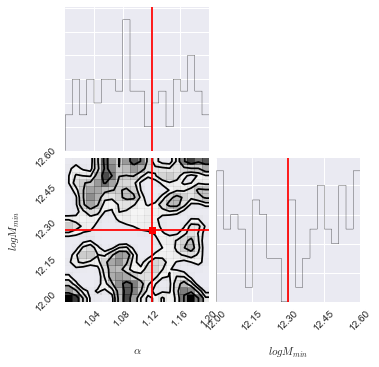

New Distance Threshold Eps_t =  6.59684240185


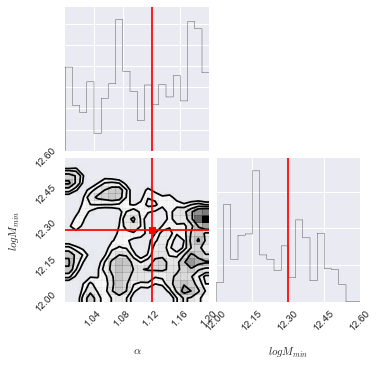

New Distance Threshold Eps_t =  4.60633417615


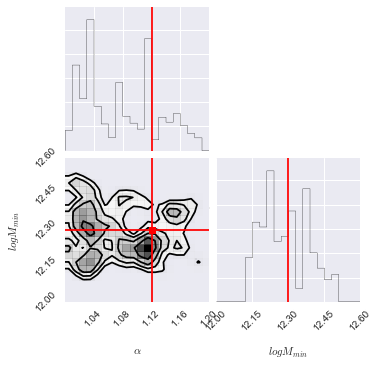

New Distance Threshold Eps_t =  3.35802246867


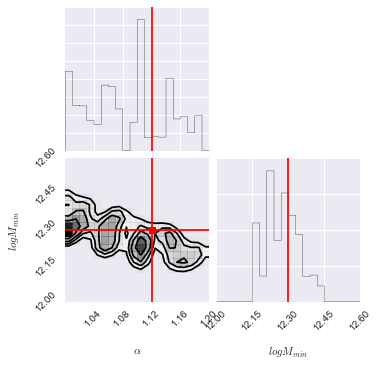

New Distance Threshold Eps_t =  2.35678140462


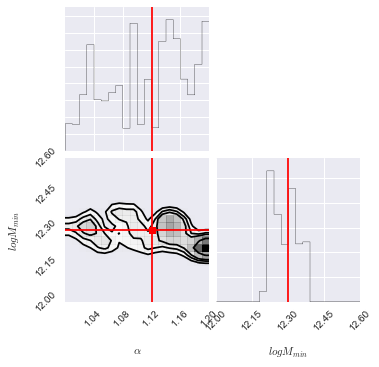

New Distance Threshold Eps_t =  1.8396411356


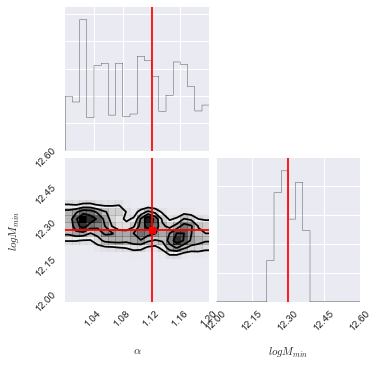

New Distance Threshold Eps_t =  1.50385638807


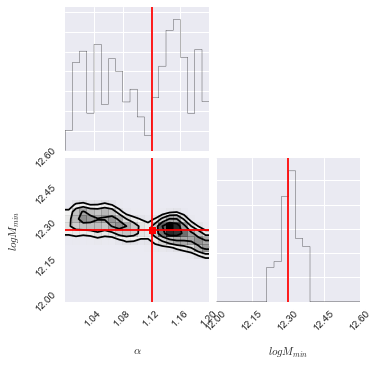

New Distance Threshold Eps_t =  1.22344460547


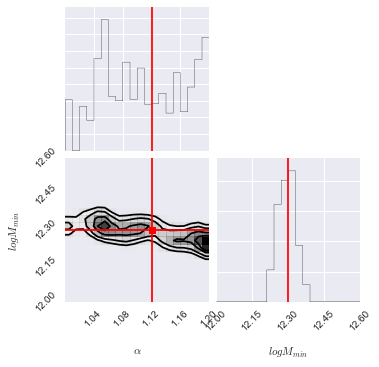

New Distance Threshold Eps_t =  1.04027786011


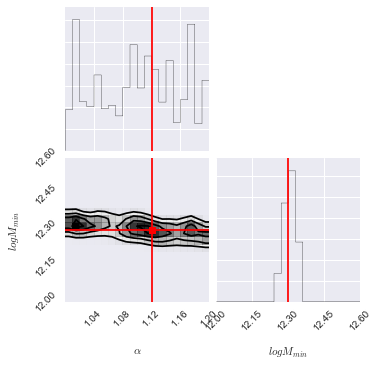

New Distance Threshold Eps_t =  0.827536590171


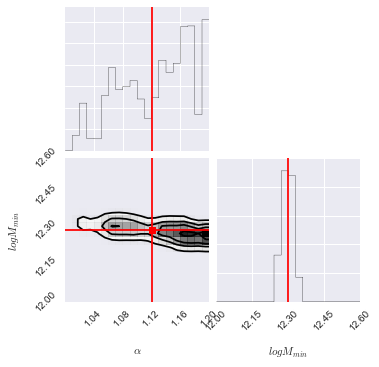

New Distance Threshold Eps_t =  0.689261395765


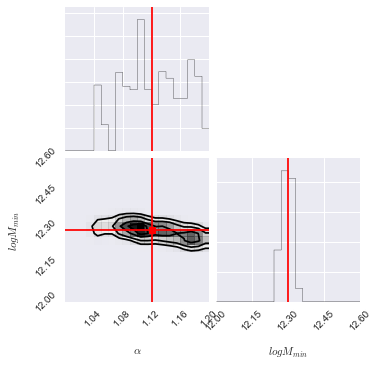

New Distance Threshold Eps_t =  0.571782463529


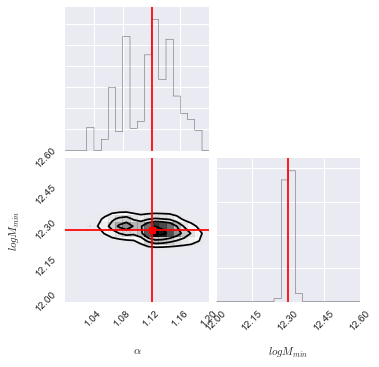

New Distance Threshold Eps_t =  0.457387944767


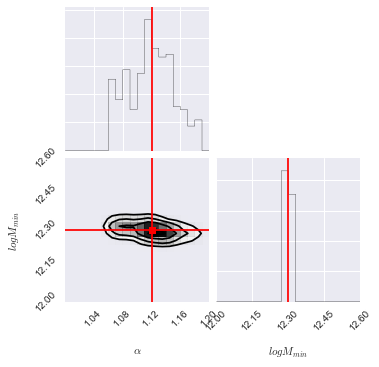

New Distance Threshold Eps_t =  0.386214124956


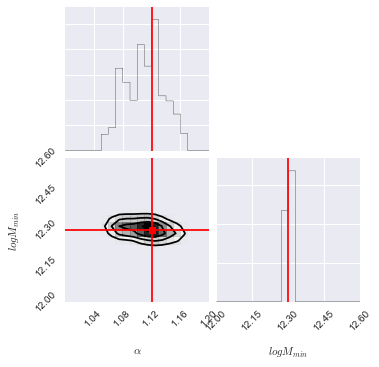

New Distance Threshold Eps_t =  0.333467397937


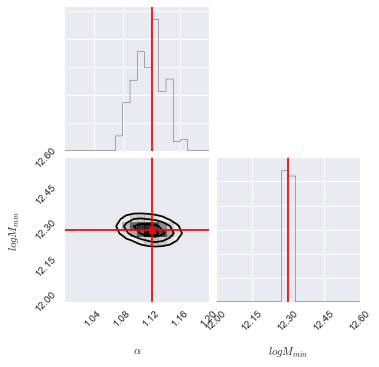

New Distance Threshold Eps_t =  0.3050496939


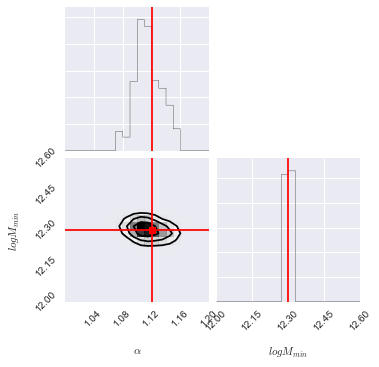

New Distance Threshold Eps_t =  0.279218909876


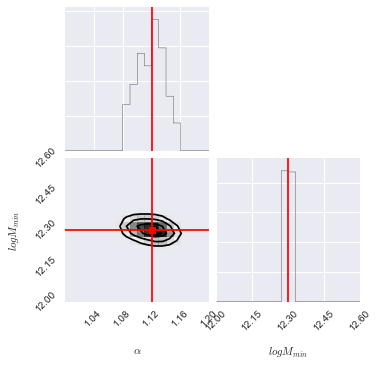

New Distance Threshold Eps_t =  0.258091468097


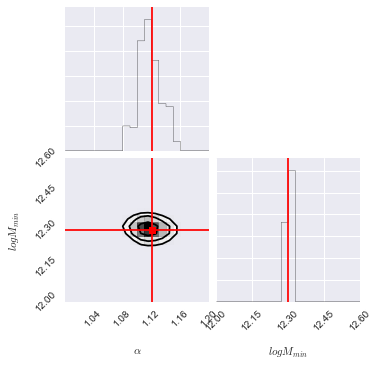

New Distance Threshold Eps_t =  0.233527568922


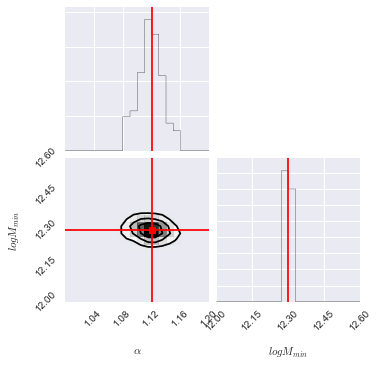

New Distance Threshold Eps_t =  0.219231505005


KeyboardInterrupt: 

In [22]:
pmc_abc()